<a href="https://colab.research.google.com/github/kndiam/hier_forecast/blob/main/Plotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tabular_palette = sns.color_palette(
    ['#6e90bf', '#aab8d0', '#4A4063','#8D7EB3',  '#d9a6a4', '#c26f6d','#8CA989','#4B6D47','#F6EFA6',])


In [ ]:
sns.set_palette(tabular_palette)

In [ ]:
def parse_measurement_file(file_path):
    # Initialize lists to store data
    models = []
    reconciliation_methods = []
    maes = []
    rmses = []

    # Regular expression patterns
    mae_pattern_with_method = re.compile(r'MAE for (.+),\s*(.+):\s*([\d.]+)')
    mae_pattern_without_method = re.compile(r'MAE for (.+):\s*([\d.]+)')
    rmse_pattern_with_method = re.compile(r'RMSE for (.+),\s*(.+):\s*([\d.]+)')
    rmse_pattern_without_method = re.compile(r'RMSE for (.+):\s*([\d.]+)')

    # Temporary storage for RMSE values to match with MAE entries
    temp_rmse = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue

            # Check for MAE entries with method
            mae_match_method = mae_pattern_with_method.match(line)
            if mae_match_method:
                model = mae_match_method.group(1).strip()
                method = mae_match_method.group(2).strip()
                mae = float(mae_match_method.group(3))

                models.append(model)
                reconciliation_methods.append(method)
                maes.append(mae)
                rmses.append(None)
                continue

            # Check for MAE entries without method
            mae_match_no_method = mae_pattern_without_method.match(line)
            if mae_match_no_method:
                model = mae_match_no_method.group(1).strip()
                mae = float(mae_match_no_method.group(2))

                models.append(model)
                reconciliation_methods.append(None)
                maes.append(mae)
                rmses.append(None)
                continue

            # Check for RMSE entries with method
            rmse_match_method = rmse_pattern_with_method.match(line)
            if rmse_match_method:
                model = rmse_match_method.group(1).strip()
                method = rmse_match_method.group(2).strip()
                rmse = float(rmse_match_method.group(3))

                # Store RMSE in temp dictionary
                temp_rmse[(model, method)] = rmse
                continue

            # Check for RMSE entries without method
            rmse_match_no_method = rmse_pattern_without_method.match(line)
            if rmse_match_no_method:
                model = rmse_match_no_method.group(1).strip()
                rmse = float(rmse_match_no_method.group(2))

                # Store RMSE in temp dictionary with method=None
                temp_rmse[(model, None)] = rmse

    # Match RMSE values with the corresponding MAE entries
    for i, (model, method) in enumerate(zip(models, reconciliation_methods)):
        if (model, method) in temp_rmse:
            rmses[i] = temp_rmse[(model, method)]

    # Create DataFrame
    data = {
        'model': models,
        'reconciliation_method': reconciliation_methods,
        'mae': maes,
        'rmse': rmses
    }

    df = pd.DataFrame(data)
    return df


In [ ]:
def create_improvement_heatmap(df):
    # Find the baseline RMSE (no reconciliation method)
    baseline = df[df['reconciliation_method'].isna()][['model', 'rmse']]
    baseline = baseline.rename(columns={'rmse': 'baseline_rmse'})
    merged_df = df.merge(baseline, on='model', how='left')
    merged_df = merged_df[merged_df['reconciliation_method'].notna()]
    merged_df['percent_improvement'] = (merged_df['baseline_rmse'] - merged_df['rmse']) / merged_df['baseline_rmse'] * 100
    merged_df.drop(columns=['rmse','baseline_rmse'],inplace=True)

    vmax = max(abs(merged_df['percent_improvement'].max()),
           abs(merged_df['percent_improvement'].min()))
    vmin = -vmax  # Ensures zero is at the center

    merged_df=merged_df.rename(columns={'reconciliation_method': 'Reconciler','model':'Model'})
    merged_df=merged_df.pivot(index="Model", columns="Reconciler", values="percent_improvement")
    # Calculate the improvement after reconciliation
    # Create custom colormap
    cmap = sns.color_palette("vlag", as_cmap=True)

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        merged_df,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        annot=True,
        fmt=".2f",
        linewidths=0.3,
    )

    # Customize the plot
    plt.title('Model Percent Improvement After Reconciliation', pad=20)


    plt.tight_layout()
    plt.show()



In [ ]:
def bar_plot(df):
  #sns.color_palette("husl", len(df['model'].unique()))
  #sns.husl_palette(s=.4)
  highlight_models = ['LinearRegression', 'NBEATSModel', 'XGBRegressor']
  colors = [
        '#6E90BF' if model.lower() in [m.lower() for m in highlight_models]
        else '#C26F6D'
        for model in df['model']
    ]
  df.sort_values(by='rmse', inplace=True)
  ax = sns.barplot(
      x='model',
      y='rmse',
      data=df,
      palette=colors,
      )
  ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=30,
        ha='right'
    )
  from matplotlib.patches import Patch
  legend_elements = [
        Patch(facecolor='#6E90BF', label='Multivariate Models'),
        Patch(facecolor='#C26F6D', label='Univariate Models')
    ]
  ax.legend(handles=legend_elements)
  ax.set_ylabel('RMSE')
  ax.set_xlabel('')
  plt.title('Baseline Model Performance', pad=20)
  plt.tight_layout()
  plt.show()

In [ ]:
def trophies(df):
  df.sort_values(by='rmse', inplace=True)
  df=df.head(5)
  ax = sns.barplot(
      x='model',
      y='rmse',
      data=df,
      palette=tabular_palette,
      )

In [ ]:
uni_multi = 'results_uni_vs_multi.txt'  # Replace with your file path
baselines = parse_measurement_file(uni_multi)
rec_file = 'results_crossmodel_reconciliation.txt'
reconciliation = parse_measurement_file(rec_file)
e_file = 'model_ensemble_performance.txt'
ensemble = parse_measurement_file(e_file)
full = pd.concat([baselines, reconciliation, ensemble])

In [ ]:
reconciliation = pd.concat([ensemble, reconciliation])

In [ ]:
full.drop_duplicates(inplace=True)


In [ ]:
trophies(full)

                  model reconciliation_method      mae      rmse
5          XGBRegressor                  MiNT  7206.94   9596.57
6          XGBRegressor                  None  9017.24  10968.69
1  ExponentialSmoothing                  None  9987.80  11312.62
8          XGBRegressor        Darts Top Down  9971.76  11489.85
0        Model Ensemble                  MiNT  9909.87  11806.17


<ipython-input-100-914ad0660f60>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-100-914ad0660f60>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


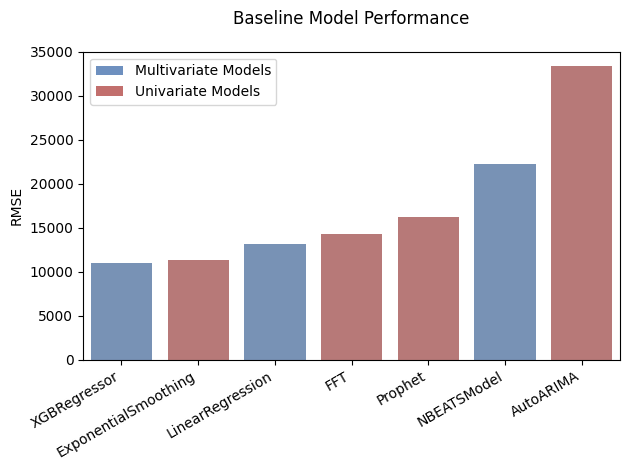

In [ ]:
bar_plot(baselines)

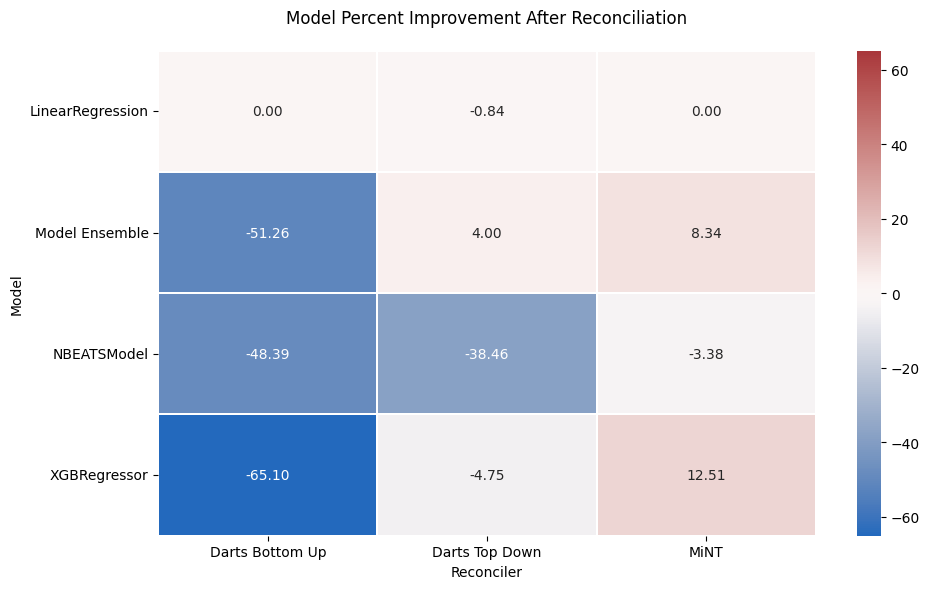

In [ ]:
create_improvement_heatmap(reconciliation)